## Optimizer

### Stochastic Gradient Descent(SGD)

$$w_{t+1} = w_t - \alpha * \frac{\partial{L}}{\partial{w_t}}$$

**Limitation**:
* Sensitive to learning rate <br>

  SGD is highly sensitive to the choice of learning rate. 

* Difficulty with Saddle points

  In high-dimensional non-convex optimization problems common in deep learning, SGD can struggle with saddle points. Unlike some more advanced optimizers, SGD doesn't have built-in mechanisms to efficiently escape saddle points

    saddle point is a point on the surface of the graph of a function where the slopes (derivatives) in orthogonal directions are all zero (a critical point), but which is not a local extremum of the function.
  
* Difficulty with finding the global minimum

  SGD may not converge precisely to the global minimum. IT may find a local optima and finds it difficult to escape the local optima
* Uniform update for all parameters

  SGD applied the same learning rate to all parameter updates.


*further reading*:
* [ML | Stochastic Gradient Descent (SGD)](https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/)

#### Exponential Moving Average

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch


In [35]:
x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)

$EMA_t = \alpha EMA_{t-1} +(1-\alpha)X_t$

In [43]:
alpha = 0.7
ema  = 0 
results = []
for i, val in enumerate(y):
    ema = alpha * ema + (1-alpha) * y[i]
    results.append(ema)
results

[0.0,
 0.1928362829059618,
 0.4304277239378357,
 0.5611070278918167,
 0.49538096252197233,
 0.24416063076768,
 -0.08889517959795554,
 -0.35766895162223133,
 -0.44320454904152373,
 -0.31024318432906667]

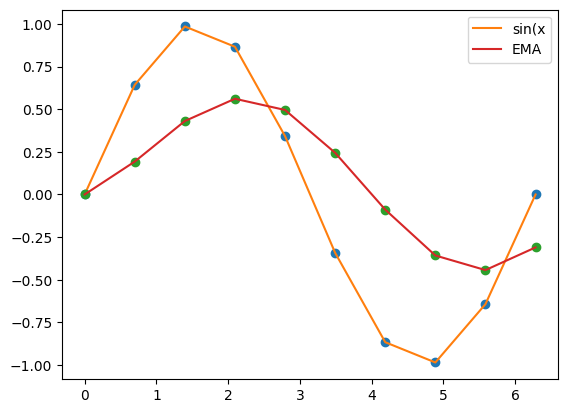

In [45]:
plt.plot(x,y, 'o')
plt.plot(x,y,'-', label='sin(x')
plt.plot(x,results, 'o')
plt.plot(x,results,'-', label='EMA')
plt.legend()

### Momentum

when calculating a current gradient, past gradients are taken into consideration. The past gradients are multiplied by the momentum coefficient $\beta$ which determines the contribution of the previous gradients to the current gradient. The concept of this momentum is similar to exponential moving average.

SGD without momentum:
$$W^{[l]} = W^{[l]} - \alpha \frac{\partial L}{\partial W^{[l]}}$$
SGD with momentum:
$$V_{dw}^{[l]}=\beta \cdot V_{dw}^{[l]} + (1-\beta) \frac{\partial L}{\partial W^{[l]}}$$
Parameter update:
$$W^{[l]} = W^{[l]} - \alpha V_{dw}^{[l]}$$

**Advantage of SGD with momentum**
* Momentum is faster than stochastic gradient descent the training will be faster than SGD.
* Local minima can be an escape and reach global minima due to the momentum involved.
  
<img src="./rsc/SGD_momentum.png" width="600" heigh="800">

*further reading*:
* [SGD with momentum](https://paperswithcode.com/method/sgd-with-momentum)

Scratch development of class `Optimizer` is dicussed in MLP-6.Optimizer.ipynb. <br>

Using this class, add momentum 

In [67]:
class MomentumOptimizer():
    def __init__(self, parameters, learning_rate=0.01, momentum=0.9):
        self.parameters = list(parameters) 
        self.lr = learning_rate
        self.momentum = momentum
        self.v = [torch.zeros_like(param) for param in self.parameters]

    """
        `zeros_list` takes tensor
        `zeros` takes shape
    """
        
    def step(self):
        with torch.no_grad():
            for param, v in zip(self.parameters, self.v):
                # wihtout `[:]`, is not replaced in self.v
                v[:] = self.momentum * v + param.grad
                param -= self.lr*v

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad = None

In [60]:
a = torch.tensor([[1,2,3,4],[5,6,7,8]])
for a_ in a:
    a_ = torch.tensor([0,0,0,0])
print(f'without replacement {a}')

a = torch.tensor([[1,2,3,4],[5,6,7,8]])
for a_ in a:
    a_[:] = torch.tensor([0,0,0,0])
print(f'with replacement {a}')


without replacement tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
with replacement tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]])


In [62]:
from functools import partial

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import init
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

%load_ext autoreload 
%autoreload 2
import utils

In [64]:
conv_model = utils.get_conv_model()
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=32, out_features=10, bias=True)
)

In [68]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))
])
train_dataset = torchvision.datasets.FashionMNIST('./data/fmnist_dataset', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.FashionMNIST('./data/fmnist_dataset', train=False, download=True, transform=transform)

batch_size=1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=6)

opt = MomentumOptimizer(conv_model.parameters(), learning_rate=0.03, momentum=0.9)
act_stats = utils.ActivationStatistics(conv_model)

num_epoch = 3
train_losses, val_losses, val_accuraccies = utils.learn(conv_model,train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epoch)


epoch: 0: train error: 1.339046649003433, validation error: 0.8108857333660126, validation accuracy: 0.7223433494567871


epoch: 1: train error: 0.6642632807715464, validation error: 0.6037213027477264, validation accuracy: 0.7849190831184387


epoch: 2: train error: 0.5383392850221214, validation error: 0.5227080702781677, validation accuracy: 0.8085718274116516


#### SGD with momentum in Pytorch

SGD takes a momentum argument in `torch.optim.SGD()

class `torch.optim.SGD`(params, lr=0.001, momentum=0, dampening=0, weight_decay=0, nesterov=False, *, maximize=False, foreach=None, differentiable=False, fused=None)

**Parameters**:
* **params** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

* **lr** (float, optional) – learning rate (default: 1e-3)

* **momentum** (float, optional) – momentum factor (default: 0)

* **weight_decay** (float, optional) – weight decay (L2 penalty) (default: 0)

### Root Mean Square Propagation (RMSProp)

SGD uniformly updates all parameters. Root mean square propagation (RMSProp) is an adaptive learning rate optimization algorithm designed to address some of the issues encountered with SGD. It means that learning rate changes over time. Do not confuse that this does not mean learning rate `lr` itself is modified. The learning rate term $(\alpha \cdot \frac{1}{\sqrt {v_{dw}^{[l]}}+\epsilon})$ is altered.

$$S_{dw}^{[l]}=\beta \cdot S_{dw}^{[l]} + (1-\beta) (\frac{\partial L}{\partial W^{[l]}})^2$$
$$W = W - \alpha \cdot \frac{\frac{\partial L}{\partial W^{[l]}}}{\sqrt {S_{dw}^{[l]}}+\epsilon}$$
        $\epsilon$ is a small constant added to the denominator to prevent division by zero.

* Increased in gradient $\frac{\partial L}{\partial W^{[l]}}$ lowers the learning rate term.
* While Decreased in gradient increases the learning rate term.
 $$\frac{\partial L}{\partial W^{[l]}}\propto \alpha \cdot \frac{1}{\sqrt {S_{dw}^{[l]}}+\epsilon}$$


[What is RMSProp?](https://deepchecks.com/glossary/rmsprop/)

In [76]:
class RMSPropOptimizer():
    def __init__(self, parameters, beta= 0.99, lr=0.01, eps=1e-8):
        self.parameters = list(parameters) 
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.sqr_avg = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        with torch.no_grad():
            for param, sqr_avg in zip(self.parameters, self.sqr_avg):
                # wihtout `[:]`, is not replaced in self.v
                sqr_avg[:] = self.beta * sqr_avg + (1- self.beta) * param.grad**2
                param -= self.lr * param.grad/(torch.sqrt(sqr_avg) + self.eps)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad = None

In [78]:
conv_model = utils.get_conv_model()
opt = RMSPropOptimizer(conv_model.parameters(), beta=0.9, lr=0.03)
act_stats = utils.ActivationStatistics(conv_model)

num_epoch = 30
train_losses, val_losses, val_accuraccies = utils.learn(conv_model,train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epoch)

epoch: 0: train error: 0.7523420771299782, validation error: 0.5924663960933685, validation accuracy: 0.7519212365150452


epoch: 1: train error: 0.44906217364941614, validation error: 0.549417358636856, validation accuracy: 0.7986108899116516


epoch: 2: train error: 0.3931382631851455, validation error: 0.5186378121376037, validation accuracy: 0.8133031725883484


epoch: 3: train error: 0.36654702435105535, validation error: 0.5423892825841904, validation accuracy: 0.8023895859718323


epoch: 4: train error: 0.33945560909933964, validation error: 0.4440872877836227, validation accuracy: 0.8435068547725677


epoch: 5: train error: 0.32621778219433156, validation error: 0.4051141768693924, validation accuracy: 0.8557417869567872


epoch: 6: train error: 0.31365615028446003, validation error: 0.3794797778129578, validation accuracy: 0.8647102177143097


epoch: 7: train error: 0.3065382459406125, validation error: 0.3825809895992279, validation accuracy: 0.8520149052143097


epoch: 8: train error: 0.298423455680831, validation error: 0.38642871379852295, validation accuracy: 0.8624242663383483


epoch: 9: train error: 0.2892875774937161, validation error: 0.37901629209518434, validation accuracy: 0.8556122422218323


epoch: 10: train error: 0.2838760738150548, validation error: 0.33522528111934663, validation accuracy: 0.8756756246089935


epoch: 11: train error: 0.2780587978787341, validation error: 0.3870773285627365, validation accuracy: 0.8583227038383484


epoch: 12: train error: 0.2725800659696935, validation error: 0.39205479323863984, validation accuracy: 0.8565748572349549


epoch: 13: train error: 0.2668528498734458, validation error: 0.3592580586671829, validation accuracy: 0.8692083835601807


epoch: 14: train error: 0.2633693768816479, validation error: 0.43326783180236816, validation accuracy: 0.8498006999492645


epoch: 15: train error: 0.2603365645065146, validation error: 0.35456166565418246, validation accuracy: 0.8747289538383484


epoch: 16: train error: 0.2547353576805632, validation error: 0.39545183479785917, validation accuracy: 0.8696368753910064


epoch: 17: train error: 0.2526128986629389, validation error: 0.3614149123430252, validation accuracy: 0.8702666640281678


epoch: 18: train error: 0.24716542762214855, validation error: 0.3319638937711716, validation accuracy: 0.8841179072856903


epoch: 19: train error: 0.2453069237329192, validation error: 0.3704505741596222, validation accuracy: 0.8712591648101806


epoch: 20: train error: 0.24324236481876696, validation error: 0.3402316361665726, validation accuracy: 0.8799426019191742


epoch: 21: train error: 0.24033012531571468, validation error: 0.44799145460128786, validation accuracy: 0.8355050206184387


epoch: 22: train error: 0.2390044452780384, validation error: 0.376758348941803, validation accuracy: 0.8689971327781677


epoch: 23: train error: 0.234685424525859, validation error: 0.3424121826887131, validation accuracy: 0.876283484697342


epoch: 24: train error: 0.23192334705490178, validation error: 0.3512133687734604, validation accuracy: 0.8754563927650452


epoch: 25: train error: 0.2318748359457921, validation error: 0.350141716003418, validation accuracy: 0.8824956178665161


epoch: 26: train error: 0.22819172704623916, validation error: 0.35438822507858275, validation accuracy: 0.8795440077781678


epoch: 27: train error: 0.2286678989559917, validation error: 0.331556636095047, validation accuracy: 0.8857242524623871


epoch: 28: train error: 0.225194476418576, validation error: 0.3379730135202408, validation accuracy: 0.8823979616165161


epoch: 29: train error: 0.22228631074145688, validation error: 0.397828271985054, validation accuracy: 0.8601263523101806


#### RMSProp in PyTorch

class `torch.optim.RMSprop` (params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, capturable=False, foreach=None, maximize=False, differentiable=False)

**Parameters**:
* **params** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

* **lr** (float, optional) – learning rate (default: 1e-2)

* **momentum** (float, optional) – momentum factor (default: 0)

* **alpha** (float, optional) – smoothing constant (default: 0.99)

* **eps** (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)

In [88]:
conv_model = utils.get_conv_model()
opt = RMSPropOptimizer(conv_model.parameters(), lr=0.03, beta=0.9)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.7464958722308531, validation error: 0.7843498051166534, validation accuracy: 0.7240015149116517


epoch: 1: train error: 0.46225646239216045, validation error: 0.5636671304702758, validation accuracy: 0.7897560596466064


epoch: 2: train error: 0.40683982634948473, validation error: 0.41132583320140836, validation accuracy: 0.8478097081184387


### Adaptive Moment Estimation (Adam)

#### Bias Correction

In the initial iterations, the EMA computed may be biased towards zero.

$$EMA_t = \alpha^{t-1}(1-\alpha)X_1+ \alpha^{t-2}(1-\alpha)X_2+\ \dots + \alpha(1-\alpha)X_{t-1}+(1-\alpha)X_t$$

Taking all coefficients:
$$\sum{\alpha ^{i} (1-\alpha)^{t-1}_{i=0}}=(1-\alpha)\frac{1-\alpha^t}{1-\alpha}=1-\alpha^t$$
$$EMA_1 = (1-\alpha)X_1$$
$$EMA_2 = \alpha EMA_{1} +(1-\alpha)X_2=\alpha (1-\alpha)X_1 +(1-\alpha)X_2$$
$$EMA_3 = \alpha EMA_{2} +(1-\alpha)X_3=\alpha (1-\alpha)X_1 +(1-\alpha)X_2 +(1-\alpha)X_3$$
RMSProp: 
$$S_{dw}^{[l]}=\beta \cdot S_{dw}^{[l]} + (1-\beta) (\frac{\partial L}{\partial W^{[l]}})^2$$

Bias correction: divided by $\frac{1} {1-\beta^t}$ 

$$S_{dw, corrected}^{[l]}=\frac{S_{dw}^{[l]}}{1-\beta^t}$$

In [86]:
# Add bias correction
class RMSPropOptimizer():
    def __init__(self, parameters, beta= 0.99, lr=0.01, eps=1e-8):
        self.parameters = list(parameters) 
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.sqr_avg = [torch.zeros_like(param) for param in self.parameters]

        self.t = 0

    def step(self):
        self.t +=1
        with torch.no_grad():
            for param, sqr_avg in zip(self.parameters, self.sqr_avg):
                # wihtout `[:]`, is not replaced in self.v
                sqr_avg[:] = self.beta * sqr_avg + (1- self.beta) * param.grad**2
                sar_avg_corrected = sqr_avg / (1- self.beta**self.t)
                param -= self.lr * param.grad/(torch.sqrt(sar_avg_corrected) + self.eps)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad = None

#### Adam

It is a combination of the gradient descent with momentum and RMSProp algorithm. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. 

First order momentum (Momentum):
$$V_{dw}^{[l]}=\beta_1 \cdot V_{dw}^{[l]} + (1-\beta_1) \frac{\partial L}{\partial W^{[l]}}$$
Second order momentum (RMSProp):
$$S_{dw}^{[l]}=\beta_2 \cdot S_{dw}^{[l]} + (1-\beta_2) (\frac{\partial L}{\partial W^{[l]}})^2$$

First order momentrum with bias correction:
$$V_{dw, corrected}^{[l]}=\frac{V_{dw}^{[l]}}{1-\beta_1^t}$$
Second order momentrum with bias correction:
$$S_{dw, corrected}^{[l]}=\frac{S_{dw}^{[l]}}{1-\beta_2^t}$$
Parameter update:
$$W^{[l]} = W^{[l]} - \alpha \cdot \frac{V_{dw,corrected}^{[l]}}{\sqrt{S_{dw, corrected}^{[l]}}+\epsilon}$$

*further reading*:
* [What is Adam Optimizer?](https://www.geeksforgeeks.org/adam-optimizer/)

In [83]:
class AdamOptimizer():
    def __init__(self, parameters, lr=0.03, beta1= 0.9, beta2=0.999, eps=1e-8):
        self.parameters = list(parameters) 
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.s = [torch.zeros_like(param) for param in self.parameters]

        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for param, v, s in zip(self.parameters, self.v, self.s):
                # first order moment
                v[:] = self.beta1 * v + (1- self.beta1) * param.grad
                # second order moment
                s[:] = self.beta2 * s + (1- self.beta2) * param.grad**2
                # first order moment correction
                v_corrected = v/(1-self.beta1**self.t)
                # second order moment correction
                s_corrected = s/(1-self.beta2**self.t)
                # update parameter
                param -= self.lr * v_corrected/(torch.sqrt(s_corrected) + self.eps)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad = None

In [85]:
conv_model = utils.get_conv_model()
opt = AdamOptimizer(conv_model.parameters(), lr=0.03, beta1=0.9, beta2=0.999)
act_stats = utils.ActivationStatistics(conv_model)

num_epoch = 30
train_losses, val_losses, val_accuraccies = utils.learn(conv_model,train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epoch)

epoch: 0: train error: 0.6460348716226675, validation error: 0.5116350412368774, validation accuracy: 0.8105687975883484


epoch: 1: train error: 0.3893389757406914, validation error: 0.4332333981990814, validation accuracy: 0.8392916917800903


epoch: 2: train error: 0.3467067530599691, validation error: 0.38587538003921507, validation accuracy: 0.8576949119567872


epoch: 3: train error: 0.32552701335842327, validation error: 0.392948654294014, validation accuracy: 0.8604372620582581


epoch: 4: train error: 0.31309588581828746, validation error: 0.4022583156824112, validation accuracy: 0.8541952311992645


epoch: 5: train error: 0.2995213580838704, validation error: 0.34705451428890227, validation accuracy: 0.8742625951766968


epoch: 6: train error: 0.28783867520801093, validation error: 0.47330659329891206, validation accuracy: 0.827941644191742


epoch: 7: train error: 0.280001098069094, validation error: 0.33678221702575684, validation accuracy: 0.87890625


epoch: 8: train error: 0.2711176114567256, validation error: 0.34577078819274903, validation accuracy: 0.8765027105808259


epoch: 9: train error: 0.2671390297049183, validation error: 0.316823273897171, validation accuracy: 0.8832110941410065


epoch: 10: train error: 0.2575080505872177, validation error: 0.33285743892192843, validation accuracy: 0.8806401491165161


epoch: 11: train error: 0.2554252582081294, validation error: 0.3323133200407028, validation accuracy: 0.8791693210601806


epoch: 12: train error: 0.2538817146066892, validation error: 0.3190419107675552, validation accuracy: 0.8870854616165161


epoch: 13: train error: 0.24574321558920004, validation error: 0.33453735411167146, validation accuracy: 0.8812420308589936


epoch: 14: train error: 0.24660050818475626, validation error: 0.370797324180603, validation accuracy: 0.8696607947349548


epoch: 15: train error: 0.24011013366408268, validation error: 0.384528911113739, validation accuracy: 0.8603993952274323


epoch: 16: train error: 0.24338363060506724, validation error: 0.32132165133953094, validation accuracy: 0.8876335322856903


epoch: 17: train error: 0.23786378487692042, validation error: 0.31517572700977325, validation accuracy: 0.8861467659473419


epoch: 18: train error: 0.23065144657078435, validation error: 0.3140158265829086, validation accuracy: 0.888671875


epoch: 19: train error: 0.22762155532836914, validation error: 0.32161292135715486, validation accuracy: 0.88515625


epoch: 20: train error: 0.22536714804374566, validation error: 0.321690508723259, validation accuracy: 0.8858697414398193


epoch: 21: train error: 0.22210089281453924, validation error: 0.3232129842042923, validation accuracy: 0.885943478345871


epoch: 22: train error: 0.22108261590286837, validation error: 0.29957559108734133, validation accuracy: 0.8919244289398194


epoch: 23: train error: 0.2167094064466024, validation error: 0.33383176624774935, validation accuracy: 0.88310546875


epoch: 24: train error: 0.21831039629750332, validation error: 0.30089555084705355, validation accuracy: 0.893951290845871


epoch: 25: train error: 0.21108427618519734, validation error: 0.3135108917951584, validation accuracy: 0.8881218135356903


epoch: 26: train error: 0.21130384656332307, validation error: 0.3104512691497803, validation accuracy: 0.8940648913383484


epoch: 27: train error: 0.20858557598065522, validation error: 0.3209662973880768, validation accuracy: 0.8848553121089935


epoch: 28: train error: 0.20689511324389506, validation error: 0.3077402517199516, validation accuracy: 0.8935008764266967


epoch: 29: train error: 0.20534984817949392, validation error: 0.3001443535089493, validation accuracy: 0.8927415490150452


#### Adam in PyTorch

class `torch.optim.Adam`(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, foreach=None, maximize=False, capturable=False, differentiable=False, fused=None)

**Parameters**:
* **params** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

* **lr** (float, Tensor, optional) – learning rate (default: 1e-3). A tensor LR is not yet supported for all our implementations. Please use a float LR if you are not also specifying fused=True or capturable=True.

* **betas** (Tuple[float, float], optional) – coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))

* **eps** (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)

In [87]:
conv_model = utils.get_conv_model()
# PytorchのAdam
opt = optim.Adam(conv_model.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.6633503118814048, validation error: 0.508118849992752, validation accuracy: 0.8142936885356903


epoch: 1: train error: 0.39322048324649617, validation error: 0.4366048663854599, validation accuracy: 0.8343949317932129


epoch: 2: train error: 0.34908862235182425, validation error: 0.41118148565292356, validation accuracy: 0.8510243952274322
